In [1]:
import geopandas as gpd
from shapely.ops import unary_union
import numpy as np
import rasterio.features

from bmi_topography import Topography
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video
from tqdm import trange

from pymt.models import Topography
from landlab import RasterModelGrid, imshow_grid, imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.drainage_plot import drainage_plot
from landlab.utils import get_watershed_mask

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 14})

<Axes: >

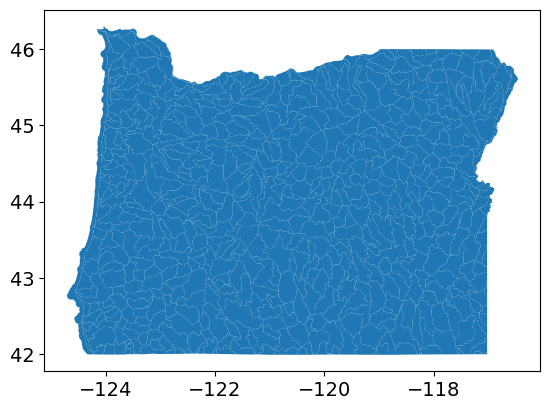

In [2]:
# Replace with your file path
gdf = gpd.read_file("../data/hydrotrend/Oregon_Watersheds%3A_10_Digit_Hydrologic_Units_(2024).geojson")

# View the first few rows
# print(gdf.head())

# Plot the geometries (optional)
gdf.plot()

In [3]:
# List of names you want to combine
names_to_combine = ['North Fork Coquille River', 'Middle Fork Coquille River',
                    'South Fork Coquille River', 'East Fork Coquille River',
                    'Coquille River']

# Filter rows where 'name' is in your list
subset = gdf[gdf['name'].isin(names_to_combine)]

<Axes: >

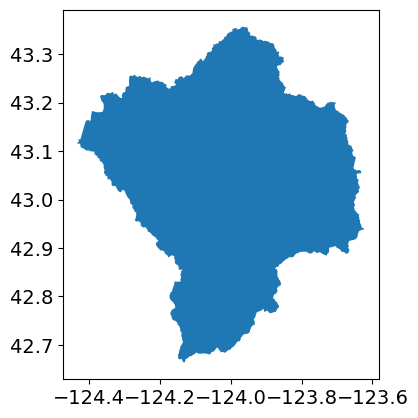

In [4]:
# Combine geometries into one using unary_union
combined_geom = unary_union(subset.geometry)

# Optional: create a new GeoDataFrame with the result
combined_gdf = gpd.GeoDataFrame(geometry=[combined_geom], crs=gdf.crs)

# View or save
combined_gdf.plot()

In [5]:
config_dir = "../data/hydrotrend"
dem = Topography()
dem.initialize(os.path.join(config_dir, 'dem.yaml'))


/opt/miniconda3/envs/landlab/lib/python3.13/site-packages/bmi_topography/api_key.py:48: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


In [6]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: degrees 
var_location: face 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 25831260 



In [7]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [2905 4446] 
grid_spacing: [0.00027778 0.00027778] 
grid_origin: [  42.60805556 -124.63694444]


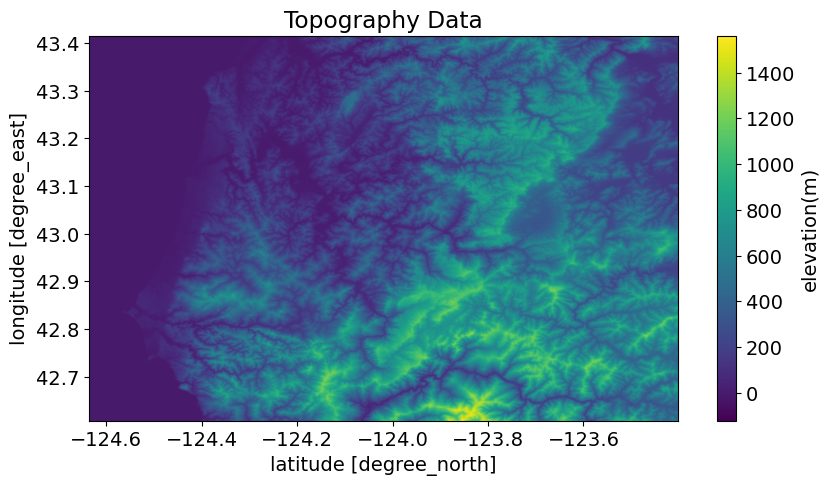

In [8]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(dem_data_2D, extent=dem_extent)
ax.title.set_text('Topography Data')
ax.set_xlabel('latitude [degree_north]')
ax.set_ylabel('longitude [degree_east]')
fig.colorbar(im,label='elevation(m)')

In [9]:
# dem_data_2D is your actual DEM array
topo = dem_data_2D
print(topo.shape)

# Assume x and y define the grid spacing (must be evenly spaced!)
x = np.linspace(min_x, max_x, topo.shape[1])
y = np.linspace(max_y, min_y, topo.shape[0])  # top to bottom

# Create affine transform (assumes regular grid)
from affine import Affine
res_x = (x[-1] - x[0]) / (len(x) - 1)
res_y = (y[0] - y[-1]) / (len(y) - 1)  # descending y
transform = Affine.translation(x[0] - res_x / 2, y[0] - res_y / 2) * Affine.scale(res_x, -res_y)

# Rasterize the polygon to create a mask
mask = rasterio.features.rasterize(
    [(combined_gdf.geometry.iloc[0], 1)],  # shapes = [(geometry, value)]
    out_shape=topo.shape,
    transform=transform,
    fill=0,
    dtype='uint8'
).astype(bool)

# Apply mask to your DEM
topo_masked = np.where(mask, topo, -9999.0)
print(topo_masked.shape)

(2905, 4446)
(2905, 4446)


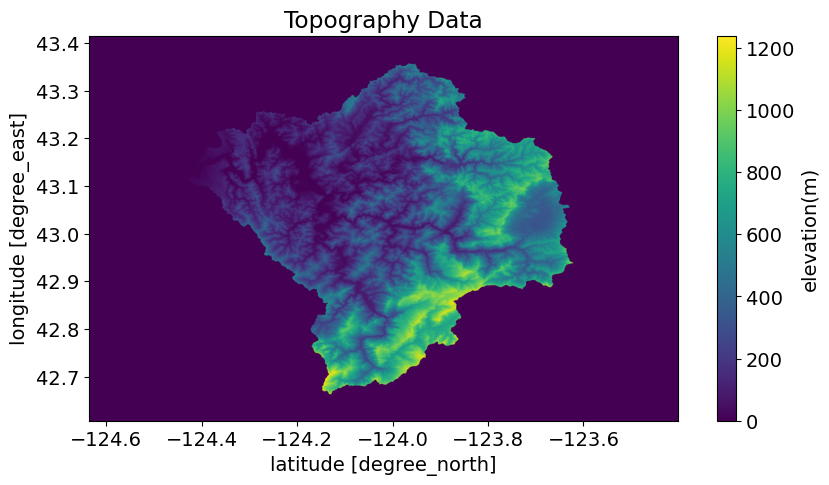

In [12]:
dem_data = np.array(topo_masked.flatten())
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(dem_data_2D, extent=dem_extent, clim=[0,np.max(dem_data)])
ax.title.set_text('Topography Data')
ax.set_xlabel('latitude [degree_north]')
ax.set_ylabel('longitude [degree_east]')
fig.colorbar(im,label='elevation(m)')

plt.savefig('coquille_watershed_topography.png', dpi=300)

Text(0, 0.5, 'north-south distance (m)')

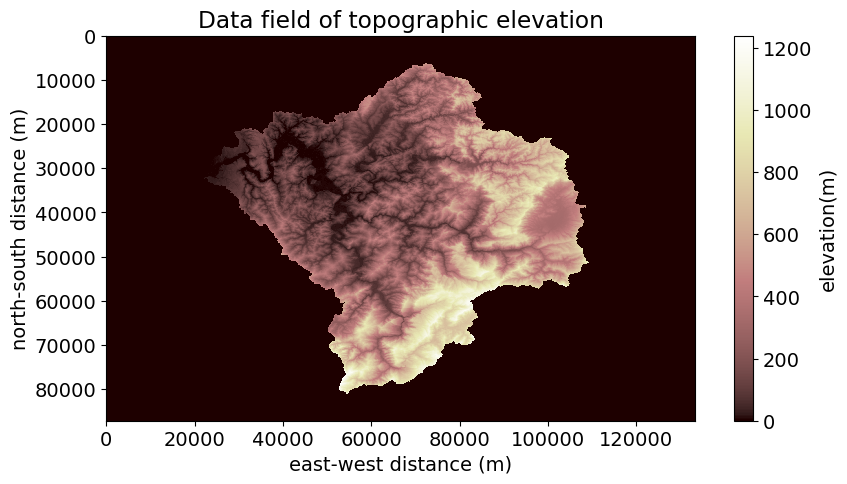

In [14]:
# set up raster model grid  
model_grid = RasterModelGrid(dem_grid_shape, xy_spacing=30)

# add topographic elevation data field
dem_field = model_grid.add_field("topographic__elevation", dem_data.astype('float'))
# dem_field = model_grid.add_zeros("topographic__elevation", at='node')
# model_grid["node"]["topographic__elevation"] = dem_data

# plot the topographic elevation data field
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(model_grid,
            'topographic__elevation',
            plot_name='Data field of topographic elevation',
            var_name='elevation(m)',
            limits=[0,np.max(dem_data)])
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')



In [161]:
watershed_mask = np.where(dem_field!=-9999.0, 1, 0)

In [162]:
# edges_eq   = np.linspace(0, dem_field.max(), 25)
# hist_eq, bin_edges = np.histogram(dem_field, bins=25, range=(0,np.max(dem_field)))

# Bin width
bin_width = 50

# Start at 1
min_edge = 1
max_edge = np.max(dem_field)

# Compute bin edges that include the max value
bin_edges = np.arange(min_edge, max_edge + bin_width, bin_width)

# Create histogram
hist_eq, _ = np.histogram(dem_field, bins=bin_edges)

In [163]:
hist_eq

array([314703, 349334, 363511, 326702, 271893, 237896, 234863, 222609,
       194205, 172313, 150848, 141129, 140918, 141386, 144154, 134489,
       101907,  78234,  64668,  45495,  32118,  21305,   9514,   3667,
          371])

In [164]:
area = np.sum(hist_eq)
area

3898232

In [165]:
hist_eq_proportion = hist_eq/area*100
hist_eq_proportion

array([8.07296744, 8.96134453, 9.32502222, 8.38077364, 6.97477728,
       6.10266398, 6.02485947, 5.71051184, 4.98187383, 4.42028591,
       3.86965168, 3.62033353, 3.61492082, 3.62692626, 3.69793281,
       3.4499999 , 2.6141851 , 2.0069098 , 1.65890588, 1.16706753,
       0.82391197, 0.54652981, 0.24405936, 0.09406829, 0.00951713])

In [166]:
check = np.sum(hist_eq_proportion)
check

100.0

In [167]:
area = model_grid.cell_area_at_node * watershed_mask
total=np.sum(area / 1e6)
total #km2

3527.9496

In [168]:
bins_elevation_sqkm = hist_eq_proportion * 1e-2 * total
bins_elevation_sqkm = np.cumsum(bins_elevation_sqkm)

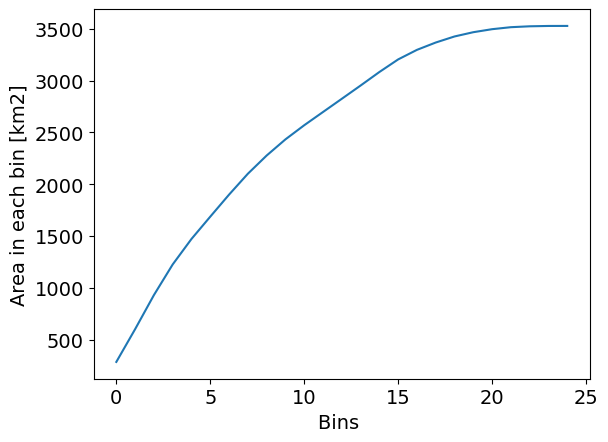

In [169]:
plt.plot(bins_elevation_sqkm[0:])
plt.xlabel("Bins ")      # ← x‑axis label
plt.ylabel("Area in each bin [km2]")
plt.show()

In [170]:
bins_elevation_sqkm.astype(float).shape

(25,)

In [171]:
bin_edges = bin_edges[0:-1]
bin_edges.shape

(25,)

In [172]:
A = np.column_stack([bin_edges, bins_elevation_sqkm.astype(float)])

In [173]:
np.savetxt('hydro_bins.txt', A, fmt=['%d','%.3f'])

In [146]:
A = bin_edges.astype(int)

In [147]:
A

array([  49,   99,  148,  198,  247,  297,  346,  396,  446,  495,  545,
        594,  644,  693,  743,  792,  842,  892,  941,  991, 1040, 1090,
       1139, 1189, 1239])